## Deep Q-Learning for Grid World Navigation

This notebook explores using deep Q-learning to solve a grid world navigation problem with dynamic obstacles. While traditional Q-learning with explicit state-action value tables works well for small state spaces, many real-world problems have state spaces that are too large to enumerate completely. Here we'll see how neural networks can be used to approximate the Q-function in these cases.

### Problem Setup

We'll work with a 10x10 grid world where an agent needs to navigate to a goal while avoiding fire that can spread randomly after each move. The state space is massive - with 100 possible agent positions and each cell either containing fire or not, there are 100 * 2^100 ≈ 10^32 possible states. This makes it impractical to store explicit Q-values for every state-action pair.

Instead, we'll use a neural network to approximate the Q-function, taking the state as input and outputting action values for moving up, down, left or right. This allows us to capture the underlying patterns in optimal behavior without having to store values for every possible state.

### Key Implementation Challenges

There are two main challenges when using neural networks for Q-learning:

1. **Catastrophic Forgetting**: Neural networks can "forget" previously learned behaviors when trained on new experiences. For example, if the network learns that moving left is good when the goal is on the left, it may overwrite this knowledge when later trained on a situation where moving left leads to failure. This is addressed using experience replay - storing past experiences in a memory buffer and training on random batches from this buffer.

2. **Training Instability**: Since the network is learning from its own predictions of future rewards, training can become unstable and diverge. This is mitigated by using separate policy and target networks:
   - The policy network determines actions and is updated regularly
   - The target network estimates future rewards and is updated less frequently by copying weights from the policy network

### Background

This approach builds on the seminal paper "Human-level control through deep reinforcement learning" (Nature, 2015) which demonstrated deep Q-learning's effectiveness on Atari games. The key insight was that neural networks could learn meaningful state representations and action-value functions directly from high-dimensional sensory inputs.

### State Representation 

The state is represented as three 10x10 grids (channels):
- Channel 1: Agent position (1 at agent location, 0 elsewhere)
- Channel 2: Fire locations (1 where fire exists, 0 elsewhere) 
- Channel 3: Goal position (fixed)

This representation allows the neural network to learn spatial patterns and relationships between the agent, obstacles, and goal.



### State representation

To represent the state we have used an array consisting of three $10\times 10$ grid layers. The first specifies the position of the player with a 1 at the position of the player, otherwise zero, and if the player has walked outside the grid all elements are zero. The second layer specifies the position of the fire, with 1 where there is a fire and 0 otherwise. The third layer represents the goal and is fixed at the same position. I.e. <code>state[:,:,0]</code> gives the grid describing the position of the player, <code>state[:,:,1]</code> position of the fire and <code>state[:,:,2]</code> position of the goal.



In [1]:
# Standard libraries
import numpy as np
import random

# Libraries for plotting
import matplotlib  
import matplotlib.pyplot as plt 
from mpl_toolkits import mplot3d
from IPython.display import display, clear_output

# For safe copy of varaibles
import copy

# Nice way of building a memory, a list with maximum size
from collections import deque
import itertools

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
torch.manual_seed(0)
np.random.seed(0)




In [2]:

class GridWorld:
     
    def __init__(self):
        # the size of the grid
        self.size = np.array([10,10])
        # number of layers in state 
        self.layers = 3
        
        # Default starting position and goal
        self.start = np.array([1,8])
        self.goalpos = np.array([8,1])      
        
        # rewards, gravel refers to an ordinary step 
        self.cliff = -100
        self.fire = -50
        self.goal = 100
        self.gravel = -1
                
        # Default values for network
        self.gamma = 0       
        # Probability of wind
        self.wind = 0
        #probability for fire to spread
        self.prob_spread = 0
        
        # Default values for epsilon greedy, not optimal, updated further down!
        self.epsilon = 1
        self.epsilon_decay = 0.99999999999999999999999999
        self.epsilon_min = 0.1
        
        # Memory, default values, not optimal, updated further down!
        self.memory_size = 1 
        self.memory = deque(maxlen=self.memory_size)
        self.batchSize = 1 
        
    # Constructs the state, random_placement is either True or False. If True the player is placed 
    # randomly, if False the player is initialized in the starting position
    
    def make_state(self, random_placement: bool):
        
        if random_placement:
            r_x = np.random.randint(self.size[0]) 
            r_y = np.random.randint(self.size[1])
            # if random = goal keep generating values 
            while r_x == self.goalpos[0] and r_y == self.goalpos[1]:
                r_x = np.random.randint(self.size[0]) 
                r_y = np.random.randint(self.size[1])
        else :
            r_x = self.start[0]
            r_y = self.start[1]
        
        # Initialize all values in all layers to zero
        state = np.zeros((self.size[0],self.size[1],self.layers))
        # we will use player_coordinate to keep track of the position of the player
        player_coordinate = [0,0]

        # Go through all layers and put 1 at the correct position
        for x in range(self.size[0]) : 
            for y in range(self.size[1]) :
            
                # Player, first layer
                if x == r_x and y == r_y :
                    state[x,y,0] = 1
                    player_coordinate[0] = x
                    player_coordinate[1] = y
                else : 
                    state[x,y,0] = 0

                       
                # Fire, second layer
                if (1<= x <=2) and (1<= y <= 2):
                    state[x,y,1] = 1    
                else :
                    state[x,y,1] = 0 
            
                #Goal, thrid layer
                if x == self.goalpos[0] and y == self.goalpos[1] :
                    state[x,y,2] = 1
                else : 
                    state[x,y,2] = 0                
    
        # return state and player_coordinate
        return state , player_coordinate 

    
    def make_move(self, state: np.ndarray, action: int, player_coordinate: np.ndarray, is_wind: bool):
        # Use deepcopy to make a copy of the state, otherwise this would just be a pointer to the same
        
        next_state = copy.deepcopy(state)
                
        if is_wind :
            if np.random.rand() < self.wind:
                # overwrite action with random action internally
                action = np.random.randint(4)
                
        new_x = player_coordinate[0]
        new_y = player_coordinate[1]
        
        # Assume that the player goes out of the board ,set old position to zero
        # and new coordinate to none
        next_state[new_x,new_y,0] = 0
        next_player_coordinate = None
        done = True
        reward = self.cliff
        
        # make move 
        if action < 2: # up or down
            if action == 0: # up
                new_y = new_y + 1
            else : # down
                new_y = new_y - 1 
        else : # left or right
            if action == 2: # left 
                new_x = new_x - 1
            else : # right
                new_x = new_x + 1   

        # If inside grid 
        if 0 <= new_x < self.size[0] and 0 <= new_y < self.size[1]:
            # if it hits the goal
            if state[new_x,new_y,2] == 1:
                done = True
                reward = self.goal
                next_state[new_x,new_y,0] = 1
                next_player_coordinate = [new_x,new_y]
            # fire # WHAT IF THE GOAL BURNS?
            elif state[new_x,new_y,1] == 1:
                done = False
                reward = self.fire
                next_state[new_x,new_y,0] = 1
                next_player_coordinate = [new_x,new_y]
            # gravel    
            else : 
                done = False 
                reward = self.gravel
                next_state[new_x,new_y,0] = 1
                next_player_coordinate = [new_x,new_y]
            
        # else, do nothing, next_player coordinate remains None and next_state[:,:,0] remains all zeros
            
        return next_state, next_player_coordinate , reward , done  

    
    def let_fire_spread(self, state: np.ndarray):
        new_state = copy.deepcopy(state)
        
        # Assume fire did not spread
        did_fire_spread = False
    
        for x in range(self.size[0]):
            for y in range(self.size[1]):
                # Walk trhough the fire-grid, if encountering fire, see if it spreads
                if state[x,y,1] == 1 : 
                    # with the probability self.prob_spread the fire spreads 
                    if np.random.rand() < self.prob_spread :
                        # a random move , no diagonal moves are allowed
                        if np.random.rand() < 0.5 :
                            x_step = np.random.randint(2)*2-1
                            y_step = 0
                        else :
                            x_step = 0
                            y_step = np.random.randint(2)*2-1
                        # if within boundaries
                        if (0<= x+x_step < self.size[0]) and (0<= y+y_step < self.size[1]):
                            # Check that this square is not allready on fire
                            if new_state[x+x_step,y+y_step,1] == 0: 
                                # LET IT BURN!
                                new_state[x+x_step,y+y_step,1] = 1
                                did_fire_spread = True
                                
        
        return new_state , did_fire_spread
    
    # This function implements training and experience replay with two approaches. The currently active approach, version 1,
    # utilizes the original predictions for target values. The alternative approach, version 2, which is currently commented out,
    # employs the target network to generate new target values for past states. Our findings suggest that version 1 is more stable
    # for this specific problem, but both versions can be experimented with.
    def replay(self, policy_model):
        if len(self.memory) < self.batchSize:
            return  # Skip training if not enough samples
            
        minibatch = random.sample(self.memory, self.batchSize)
        
        state_batch = torch.FloatTensor(np.array([m[0] for m in minibatch]))
        target_batch = torch.FloatTensor(np.array([m[1] for m in minibatch]))

        # Prioritize goal states in training
        for _ in range(5):  # Multiple passes over each batch
            policy_model.optimizer.zero_grad()
            
            current_q_values = policy_model(state_batch)
            target_q_values = target_batch.clone()
            
            # Update targets with more emphasis on goal states
            for i, (_, _, action, reward, _, next_q_max, done) in enumerate(minibatch):
                if done and reward == self.goal:  # Goal state
                    target_q_values[i][action] = reward * 1.2  # Boost goal state values
                elif done:  # Failed state
                    target_q_values[i][action] = reward
                else:  # Normal state
                    target_q_values[i][action] = reward + self.gamma * next_q_max
            
            loss = policy_model.loss_fn(current_q_values, target_q_values)
            loss.backward()
            
            # Add gradient clipping
            torch.nn.utils.clip_grad_norm_(policy_model.parameters(), max_norm=1.0)
            
            policy_model.optimizer.step()
            
    # Used to display the grid
    def make_RGB_grid(self,state,path):
        grid_RGB = np.ones((self.size[0],self.size[1],3))*0.7 #
        
        if path is not None :
            for i,location in enumerate(path):
                grid_RGB[location[0],location[1],:] = np.array([0,0,0]) # black'P' #player
    
        for x in range(self.size[0]) : 
            for y in range(self.size[1]) :
            
                if state[x,y,2]==1:
                    grid_RGB[x,y,:] = np.array([245/255,237/255,48/255]) # Yellow
                
                if state[x,y,1]==1:
                    grid_RGB[x,y,:] = np.array([203/255,32/255,40/255]) # Red '-' #pit    
   
                if state[x,y,0]==1:
                    grid_RGB[x,y,:] = np.array([0/255,254/255,0/255]) # Green '-' #pit    
   
        return grid_RGB

# Define the network

In [3]:
class QNetwork(nn.Module):
    def __init__(self, world):
        super(QNetwork, self).__init__()
        # Conv layers
        self.conv1 = nn.Conv2d(world.layers, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.batch_norm = nn.BatchNorm2d(32)
        
        # Calculate flattened size
        # After first conv (10x10) -> pool (5x5) -> second conv (5x5)
        self.flatten_size = 32 * 5 * 5
        
        # Dense layers
        self.fc1 = nn.Linear(self.flatten_size, 64)
        self.fc2 = nn.Linear(64, 4)
        
        # Optimizer and loss
        self.optimizer = optim.Adam(self.parameters(), lr=0.005)  #
        self.loss_fn = nn.MSELoss()
        
    def forward(self, x):
        # Ensure input is in correct format (batch_size, channels, height, width)
        if len(x.shape) == 3:
            x = x.unsqueeze(0)
        x = x.permute(0, 3, 1, 2)  # (batch, channels, height, width)
        
        # Convolutional layers
        x = F.relu(self.conv1(x))   # (batch, 32, 10, 10)
        x = self.pool(x)            # (batch, 32, 5, 5)
        x = F.relu(self.conv2(x))   # (batch, 32, 5, 5)
        x = self.batch_norm(x)
        
        # Flatten and dense layers
        x = x.reshape(-1, self.flatten_size)  # Changed from view to reshape
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def setup_network(world):
    model = QNetwork(world)
    return model


The network architecture is designed to process visual inputs effectively. It begins with a convolutional layer that transforms the input into a feature map of size (8, 8, 32). This is followed by a max pooling layer, which reduces the spatial dimensions to (4, 4, 32) while retaining the most important features. This process not only extracts key features but also reduces the number of parameters, making the network more efficient. The output is then fed into another convolutional layer, resulting in a feature map of size (2, 2, 32). A batch normalization layer is applied to stabilize the training process by normalizing the activations. The output is then flattened into a 1-dimensional vector of size 128, preparing it for the dense layers. The first dense layer has 64 output values, allowing the network to learn more complex representations. Finally, the output is fed into a second dense layer with 4 output values, suitable for the task at hand.



# Setup network and GridWorld

### Policy Network and Target Network in Deep Q-Learning

Deep Q-Learning uses two neural networks - a policy network and a target network - to improve training stability and performance.

#### Policy Network
The policy network is the primary network that:
- Actively learns from experiences
- Determines which actions to take during gameplay
- Gets updated frequently through experience replay
- Receives gradient updates based on the loss between predicted and target Q-values

#### Target Network
The target network is a periodic copy of the policy network that:
- Updates less frequently (every N episodes)
- Provides stable target Q-values for training
- Helps prevent oscillations and divergence in training

#### Why Two Networks?
Using two networks addresses a fundamental challenge in Q-learning called the "moving targets" problem:

1. If we used a single network, we would be trying to predict Q-values while simultaneously using those same predictions as training targets. This creates an unstable feedback loop.

2. By using a separate target network that updates less frequently, we create more stable target values. The policy network can learn against these fixed targets, making the training process more reliable.

3. This approach helps break the correlation between predictions and targets, reducing harmful feedback loops that could destabilize training.

In our implementation:
- The policy network is updated every 10 games through experience replay
- The target network is updated every `update_target_network_period` games by copying weights from the policy network
- The target network provides the Q-value estimates used in calculating training targets, while the policy network determines actual gameplay actions

QNetwork(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=800, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=4, bias=True)
  (loss_fn): MSELoss()
)


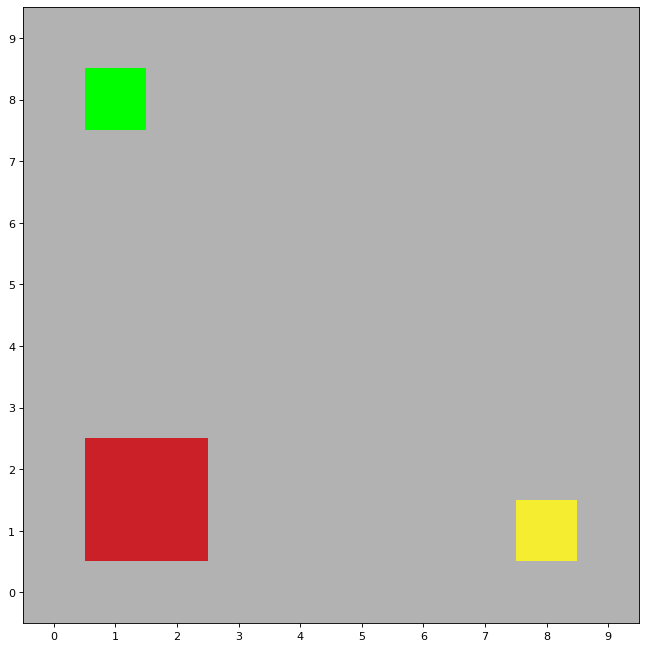

In [4]:
# Setup GridWorld and Q-networks

# Create world from GridWorld
world = GridWorld()
# Setup network
policy_model = setup_network(world)
#make a target network as well
target_model = setup_network(world)
# copy weights from policy to target
target_model.load_state_dict(policy_model.state_dict())

# Print model architecture
print(policy_model)

#Make state 
state , player_coordinate = world.make_state(False)

# plot it 
grid_RGB =world.make_RGB_grid(state,None)
#
fig=plt.figure(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')
# We have to invert the x and y axis , go over to numpy array instead
plt.imshow(np.swapaxes(np.array(grid_RGB),0,1))
#plt.axis('on')
plt.gca().invert_yaxis()
plt.xticks(np.arange(0, world.size[0], dtype=int))
plt.yticks(np.arange(0, world.size[1], dtype=int))
plt.show()


# Train network on model 

HERE YOU NEED TO DEFINE PARAMETER VALUES

In [5]:
# Setup system parameters

world.gamma = 0.99
world.epsilon_decay = 0.99 #multiplicative factor that reduces epsilon each step, for no reduction use 1
world.epsilon = 0.9  #initial value of epsilon 
world.wind = 0.1
# fire spreading
world.prob_spread = 0.3 # 

#update the target network every "update_target_network_period game". Updating target network less often should make
#the system more stable, but also convergence slower
update_target_network_period = 20

#define size of experience replay buffer (how many moves are stored for training) 
#and batchsize (how many moves from memory buffer are used in each training instance)
world.memory_size = 10000
        
world.batchSize = 128
world.memory = deque(maxlen=world.memory_size)   #The experience replay memory


Diagnostics. These are used to store the max and min, q-values output by the network for the states visited since the last time the target network was updated. If the training has converged these should correspond quite well to the maximal and minimal rewards available in the game. 

In [6]:
#For training diagnostics.  
q_max = 0
q_min = 0


The main loop. It should be all set to run if you have defined the network and parameters above. 

In [7]:
# MAIN LOOP with network
step_count = 0
random_start = True  # Easier to train from random start
is_wind = False  # Set to false to simplify training 
next_player_coordinate = None
nr_games = 3000  

# Set networks to training mode
policy_model.train()
target_model.eval()  # Target network should be in eval mode

for games in range(nr_games):
    # Display
    print("Game #: %s" % (games,))
    print("Epsilon : %7.4f" % world.epsilon)     
    print("Step count : %s" % step_count) 
    print("End pos %s" % next_player_coordinate)
    print("Since updated target: Qmin  %s Qmax %s" % (q_min,q_max))
    
    # Initialize new game
    state, player_coordinate = world.make_state(random_start)
    step_count = 0

    while True:
        step_count += 1
        
        # Convert state to tensor and get Q-values
        state_tensor = torch.FloatTensor(state).unsqueeze(0)  # Add batch dimension
        with torch.no_grad():
            q_state = policy_model(state_tensor).squeeze(0).detach().numpy()
        
        # Epsilon-greedy action selection
        action = np.argmax(q_state) if np.random.rand() > world.epsilon else np.random.randint(4)
        
        # Make move
        next_state, next_player_coordinate, reward, done = world.make_move(state, action, player_coordinate, is_wind)
        
        # Get next state max Q-value using target network
        next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0)
        with torch.no_grad():
            next_q_max = target_model(next_state_tensor).max().item()
        
        # Store experience
        world.memory.append((state, q_state, action, reward, next_state, next_q_max, done))
        
        # Update diagnostics
        q_max = max(q_max, np.max(q_state))
        q_min = min(q_min, np.min(q_state))
        
        # Check if episode is done
        if done or step_count > 400:
            break
            
        # Update state and handle fire spread
        state = next_state
        player_coordinate = next_player_coordinate
        new_state, fire_spread = world.let_fire_spread(state)
        if fire_spread:
            state = new_state
    
    # Training phase (every 10 games)
    if games % 10 == 0 and games > 0:
        world.replay(policy_model)
        
        # Epsilon decay
        if world.epsilon > world.epsilon_min:
            world.epsilon *= world.epsilon_decay
    
    # Update target network
    if games % update_target_network_period == 0:
        print("Update target network")
        target_model.load_state_dict(policy_model.state_dict())
        q_max = 0
        q_min = 0
    
    clear_output(wait=True)

Game #: 2999
Epsilon :  0.0996
Step count : 7
End pos [8, 1]
Since updated target: Qmin  -49.91869 Qmax 110.73793


# Plotting : State value function

<Figure size 640x480 with 0 Axes>

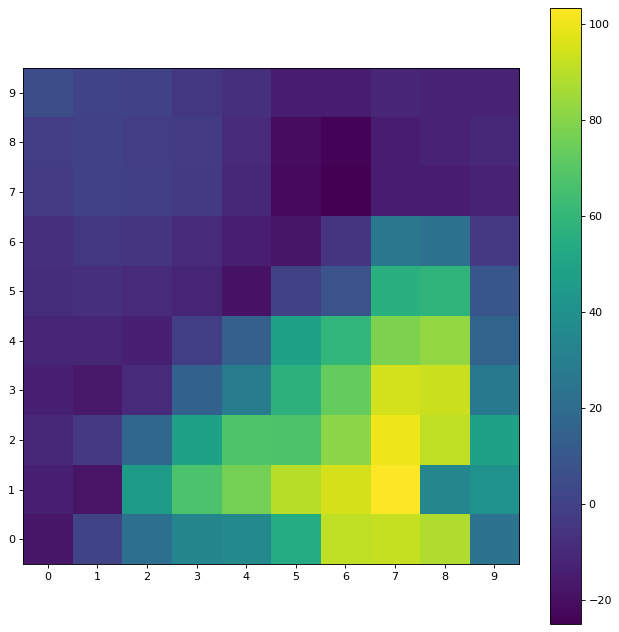

In [10]:
# State value function of network, i.e. max over actions of the Q-function

# Initialize state, this means that the fire is in the starting position
state, player_coordinate = world.make_state(False)

# set position to zero
state[player_coordinate[0],player_coordinate[1],0] = 0

# to plot
z = np.zeros((world.size[0],world.size[1]))

# Set model to evaluation mode
policy_model.eval()

# Go through all possible position of the player and calculate the value of the best action
# according to the network
with torch.no_grad():  # Disable gradient computation for inference
    for x in range(world.size[0]):
        for y in range(world.size[1]):
            player_coordinate = [x,y]
            state[player_coordinate[0],player_coordinate[1],0] = 1
            
            # Convert state to tensor
            state_tensor = torch.FloatTensor(state).unsqueeze(0)  # Add batch dimension
            
            # Get Q-values and convert to numpy
            q_state = policy_model(state_tensor).squeeze(0).numpy()
            z[x,y] = q_state.max()
            
            # Reset state
            state[x,y,0] = 0

# Set model back to training mode
policy_model.train()

# Plot        
plt.figure()
fig = plt.figure(figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
plt.imshow(np.swapaxes(z,0,1))
plt.colorbar()
plt.gca().invert_yaxis()
plt.xticks(np.arange(0, world.size[0], dtype=int))
plt.yticks(np.arange(0, world.size[1], dtype=int))
plt.show()

# Plotting : Dynamic play

To challenge the agent increase the probability of fire spread, and turn on and increase the wind.

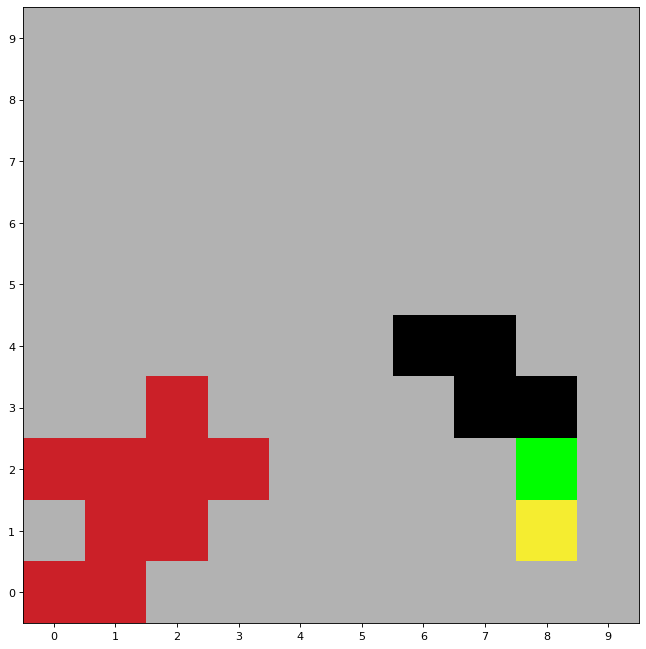

QNetwork(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=800, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=4, bias=True)
  (loss_fn): MSELoss()
)

In [11]:
# dynamic game replay

for a in range(1):
    # fire spreading
    world.prob_spread = 0.6
    world.wind = 0.1
    is_wind = True

    # get original state  
    state, player_coordinate = world.make_state(True)
    path = np.array([player_coordinate])
    
    # setup figure
    fig = plt.figure(figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')

    # Set model to evaluation mode
    policy_model.eval()

    done = False
    count = 0
    while (not done) and (count < 40):
        count = count + 1
        
        # plot it 
        plot_grid = world.make_RGB_grid(state, path)
        plt.imshow(np.swapaxes(np.array(plot_grid), 0, 1))
        plt.gca().invert_yaxis()
        plt.xticks(np.arange(0, world.size[0], dtype=int))
        plt.yticks(np.arange(0, world.size[1], dtype=int))
        # clear figure and wait
        clear_output(wait=True)
        display(fig)

        # find action using PyTorch
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            q_state = policy_model(state_tensor).squeeze(0).numpy()
            
        # get best action, no epsilon greedy
        action = np.argmax(q_state)      
        
        # make the move
        next_state, next_player_coordinate, reward, done = world.make_move(state, action, player_coordinate, is_wind)

        # update state 
        state = next_state
        player_coordinate = next_player_coordinate

        if not done:
            path = np.append(path, [player_coordinate], axis=0)

        # let fire spread
        new_state, fire_spread = world.let_fire_spread(state)
        if fire_spread:
            state = new_state 
        
        if int(state[:, :, 1][player_coordinate[0], player_coordinate[1]]) == 1:
            break
        

    plt.close()

# Set model back to training mode
policy_model.train()